In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Entropy of Real Cell

In [94]:
def Entropy(rstate, binnum, overlap = True):
    rstate[rstate>1] = 1
    wordsCollection = []
    if overlap:
        for i in np.arange(0,len(rstate)-binnum+1):
            wordsCollection.append(rstate[i:i+binnum])
    else:
        for i in np.arange(0,len(rstate)-binnum+1,binnum):
            wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    entropy = -np.sum(P*np.log2(P))
    return entropy

# Load Data and Check Input

In [95]:
dt = 0.01

annots = loadmat('D:\\GoogleDrive\\retina\\Exps\\2021\\1103\\SplitData\\diode_repeat_OU_tau=500ms_cutoff=1_mean=13_C=0.3_03-Nov-2021_0', squeeze_me = True)
sampling_rate = 20000

TicTocer = annots['a_data'][1]
startTime = np.where(TicTocer>38000)[0][0]/sampling_rate
endTime = np.where(TicTocer>38000)[0][-1]/sampling_rate
x = annots['a_data'][0, int(startTime*sampling_rate):int(endTime*sampling_rate)+1]
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
T = np.arange(len(x))*dt

channelnumber = 53
Spike = annots['Spikes'][channelnumber-1]
Spike = Spike[np.where(Spike>startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime

Text(0, 0.5, 'normalized centered stimulus (20 trials)')

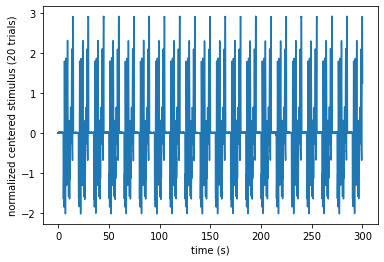

In [96]:
plt.plot(T,x)
plt.xlabel('time (s)')
plt.ylabel('normalized centered stimulus (20 trials)')

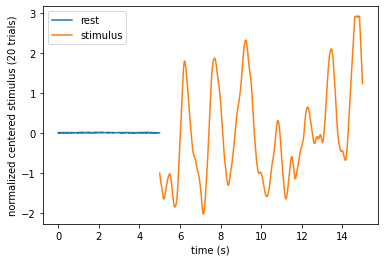

In [97]:
restTime = 5
stiTime = 10
trial = 20

plt.plot(T[:int(restTime/dt)], x[:int(restTime/dt)], label ='rest')
plt.plot(T[int(restTime/dt):int((restTime+stiTime)/dt)], x[int(restTime/dt):int((restTime+stiTime)/dt)], label ='stimulus')
plt.xlabel('time (s)')
plt.ylabel('normalized centered stimulus (20 trials)')
plt.legend()

In [98]:
trial = 20
x_trial = [0]*trial
delayCorrection = [0]*trial
for i in range(trial):
    startTime = restTime+i*(restTime+stiTime)
    endTime = (i+1)*(restTime+stiTime)
    x_trial[i] = x[int(startTime/dt):int(endTime/dt)]
    if i == 0:
        center = np.argmax(np.correlate(x_trial[0], x_trial[0], 'same'))
    else:
        delayCorrection[i] = np.argmax(np.correlate(x_trial[i], x_trial[0], 'same'))-center

In [99]:
delayCorrection

[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 7, 7]

# Information (R_info)

In [100]:
def R_info(rstate_trial, binnum, overlap = False):
    rstate_trial = np.array(rstate_trial)
    wordsCollection = []
    for rstate in rstate_trial:
        rstate[rstate>1] = 1
        if overlap:
            for i in np.arange(0,len(rstate)-binnum+1):
                wordsCollection.append(rstate[i:i+binnum])
        else:
            for i in np.arange(0,len(rstate)-binnum+1,binnum):
                wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    trial_num = rstate_trial.shape[0]
    event_num = int(len(wordsCollection)/rstate_trial.shape[0])

    subEntropy = 0
    for i in range(event_num):
        subSet = []
        for j in range(trial_num):
            subSet.append(wordsCollection[event_num*j+i])
        _, index = np.unique(np.array(subSet), axis = 0, return_inverse=True)
        N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/event_num
    return totalEntropy, noiseEntropy

In [101]:
def R_info2(rstate_trial):
    rstate_trial = np.array(rstate_trial)
    rstate = rstate_trial.flatten()
    N, _ = np.histogram(rstate,bins=np.append(np.unique(rstate),max(rstate)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    subEntropy = 0
    for i in range(rstate_trial.shape[1]):
        rstate = rstate_trial[:,i]
        N, _ = np.histogram(rstate,bins=np.append(np.unique(rstate),max(rstate)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/rstate_trial.shape[1]
    return totalEntropy, noiseEntropy

In [102]:
binLen = dt/10
binNum = 10

## Cut Trial (Stimulus)

In [103]:
Spike_Trial = [0]*trial
rstate_Trial = [0]*trial
for i in range(trial):
    startTime = restTime+i*(restTime+stiTime)+delayCorrection[i]*dt
    endTime = (i+1)*(restTime+stiTime)+delayCorrection[i]*dt
    Spike_Trial[i] = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+binLen,binLen))

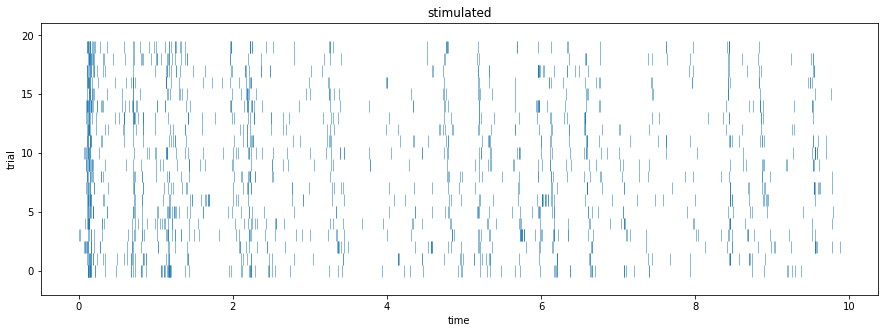

In [104]:
fig, ax = plt.subplots()
ax.eventplot(Spike_Trial, linewidths=0.5)
ax.set_title('stimulated')
ax.set_xlabel('time')
ax.set_ylabel('trial')
# ax.set_xlim(4,6)
fig.set_size_inches(15, 5)

In [105]:
totalEntropy, noiseEntropy = R_info(rstate_Trial, binNum)
totalEntropy, noiseEntropy, totalEntropy-noiseEntropy, (totalEntropy-noiseEntropy)/totalEntropy

(0.5951711543279609,
 0.3289867176773742,
 0.26618443665058666,
 0.4472401505263634)

In [106]:
for i in range(trial):
    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+dt,dt))
totalEntropy, noiseEntropy = R_info2(rstate_Trial)
totalEntropy, noiseEntropy, totalEntropy-noiseEntropy, (totalEntropy-noiseEntropy)/totalEntropy

(0.39116045904608443,
 0.2678084087133188,
 0.12335205033276564,
 0.3153489763090624)

## Cut Trial (Rest)

In [107]:
Spike_Trial = [0]*trial
rstate_Trial = [0]*trial
for i in range(trial):
    startTime = i*(restTime+stiTime)+delayCorrection[i]*dt
    endTime = i*(restTime+stiTime)+restTime+delayCorrection[i]*dt
    Spike_Trial[i] = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+binLen,binLen))

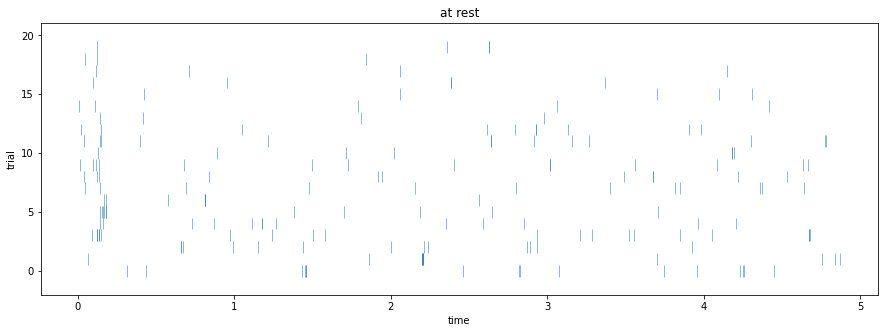

In [108]:
fig, ax = plt.subplots()
ax.eventplot(Spike_Trial, linewidths=0.5)
ax.set_title('at rest')
ax.set_xlabel('time')
ax.set_ylabel('trial')
fig.set_size_inches(15, 5)

In [109]:
totalEntropy, noiseEntropy = R_info(rstate_Trial, binNum)
totalEntropy, noiseEntropy, totalEntropy-noiseEntropy, (totalEntropy-noiseEntropy)/totalEntropy

(0.09927879190363148,
 0.04646895434551655,
 0.05280983755811493,
 0.5319347319352625)